In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

# This is the standard path for files uploaded directly to the sidebar
file_path = '/content/drive/MyDrive/AQI_HISTORICAL_RAW_DATA/karachi_raw_hourly.csv'

# Load with the critical parse_dates setting
df = pd.read_csv(file_path, parse_dates=['time'])

# Verification: Ensure 'time' is actually a datetime object
print(f"Data successfully loaded from: {file_path}")
print(f"Time column type: {df['time'].dtype}")

Data successfully loaded from: /content/drive/MyDrive/AQI_HISTORICAL_RAW_DATA/karachi_raw_hourly.csv
Time column type: datetime64[ns]


In [ ]:
# 1. Create a "Perfect Timeline" for Karachi
# From the very first hour to the very last hour in your dataset
perfect_timeline = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='H')

# 2. Check for missing links
missing_hours = perfect_timeline.difference(df['time'])

print(f"Total hours expected: {len(perfect_timeline)}")
print(f"Total hours present: {len(df)}")
print(f"Holes in data: {len(missing_hours)}")

if not missing_hours.empty:
    print(f"First gap found at: {missing_hours[0]}")

Total hours expected: 2232
Total hours present: 2232
Holes in data: 0


/tmp/ipython-input-1664361522.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  perfect_timeline = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq='H')


In [ ]:
# 1. Convert CO from ug/m3 to ppm
# Formula: (ug/m3 * 24.45) / (molecular_weight * 1000). For CO, MW is 28.01.
df['co_ppm'] = (df['carbon_monoxide'] * 24.45) / (28.01 * 1000)

# 2. Rename columns for cleaner EDA
df = df.rename(columns={'temperature_2m': 'temp', 'relative_humidity_2m': 'humidity'})

# 3. Quick Check: Do the numbers look 'real' for Karachi?
print(f"Average Karachi Temp: {df['temp'].mean():.1f}°C")
print(f"Max PM2.5 recorded: {df['pm2_5'].max()} µg/m³")

Average Karachi Temp: 24.8°C
Max PM2.5 recorded: 96.4 µg/m³


In [ ]:
# Focus on pollutants and weather
stats = df[['pm2_5', 'pm10', 'co_ppm', 'temp', 'humidity']].describe()

# Add a row for 'Variance' to see how much the air quality fluctuates in Karachi
stats.loc['var'] = df[['pm2_5', 'pm10', 'co_ppm', 'temp', 'humidity']].var()

print("--- Karachi Air Quality & Weather Statistics ---")
display(stats)

--- Karachi Air Quality & Weather Statistics ---


,pm2_5,pm10,co_ppm,temp,humidity
count,2232.000000,2232.000000,2232.000000,2232.000000,2232.000000
mean,36.561918,46.414875,0.749370,24.785036,49.952509
std,15.369231,27.066211,0.471988,4.836138,21.914763
min,7.000000,7.600000,0.064595,14.200000,7.000000
25%,25.900000,31.200000,0.399571,20.900000,32.000000
50%,34.850000,41.000000,0.638965,24.900000,47.000000
75%,44.800000,54.825000,0.987253,27.900000,68.000000
max,96.400000,262.600000,3.941155,36.500000,99.000000
var,236.213269,732.579797,0.222773,23.388230,480.256820


In [ ]:
# Find the top 10 most polluted hours
top_polluted = df.nlargest(10, 'pm2_5')[['time', 'pm2_5', 'temp', 'humidity', 'co_ppm']]

print("Top 10 Most Polluted Hours in Karachi:")
display(top_polluted)

Top 10 Most Polluted Hours in Karachi:


,time,pm2_5,temp,humidity,co_ppm
744,2025-11-01 00:00:00,96.4,26.3,34,1.006457
741,2025-10-31 21:00:00,95.7,30.8,30,1.886342
745,2025-11-01 01:00:00,95.7,25.1,38,0.656423
743,2025-10-31 23:00:00,95.5,27.6,30,1.323320
742,2025-10-31 22:00:00,95.0,29.8,26,1.621853
740,2025-10-31 20:00:00,93.6,29.8,51,1.931733
739,2025-10-31 19:00:00,93.1,29.8,56,1.577335
746,2025-11-01 02:00:00,91.3,24.6,40,0.413756
2229,2026-01-01 21:00:00,90.1,20.1,62,1.373949
767,2025-11-01 23:00:00,89.9,25.0,71,1.206351


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-4084901512.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Concentration ($\mu g/m^3$)')


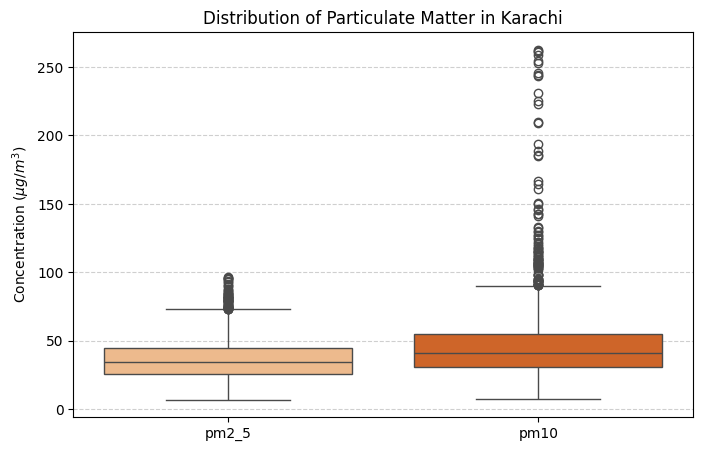

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=df[['pm2_5', 'pm10']], palette="Oranges")
plt.title('Distribution of Particulate Matter in Karachi')
plt.ylabel('Concentration ($\mu g/m^3$)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

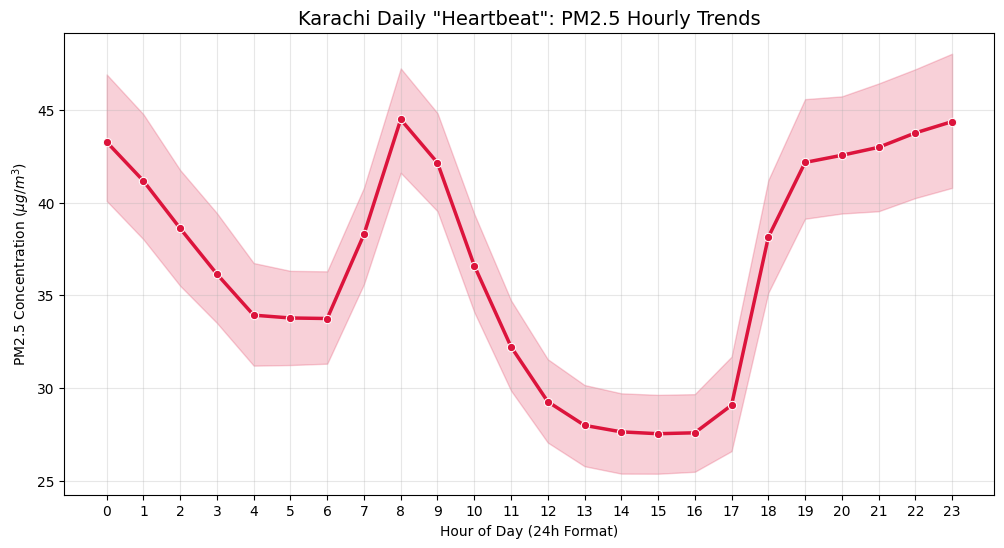

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Extract the hour
df['hour'] = df['time'].dt.hour

plt.figure(figsize=(12, 6))
# Lineplot with mean and confidence interval
sns.lineplot(data=df, x='hour', y='pm2_5', color='crimson', linewidth=2.5, marker='o')

plt.title('Karachi Daily "Heartbeat": PM2.5 Hourly Trends', fontsize=14)
plt.xlabel('Hour of Day (24h Format)')
plt.ylabel(r'PM2.5 Concentration ($\mu g/m^3$)') # Added 'r' to fix the Warning
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.show()

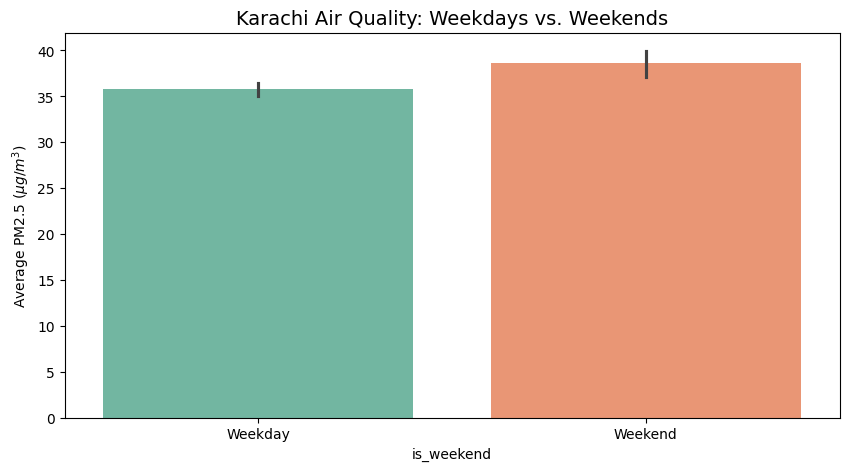

is_weekend
Weekday    35.764552
Weekend    38.616667
Name: pm2_5, dtype: float64


In [ ]:
# 2. Create Weekend vs Weekday flag
df['day_name'] = df['time'].dt.day_name()
df['is_weekend'] = df['time'].dt.dayofweek.isin([5, 6]).map({True: 'Weekend', False: 'Weekday'})

plt.figure(figsize=(10, 5))
# Barplot comparing the two
sns.barplot(data=df, x='is_weekend', y='pm2_5', palette='Set2', hue='is_weekend', legend=False)

plt.title('Karachi Air Quality: Weekdays vs. Weekends', fontsize=14)
plt.ylabel(r'Average PM2.5 ($\mu g/m^3$)')
plt.show()

# Print the actual numbers for your report
print(df.groupby('is_weekend')['pm2_5'].mean())

/tmp/ipython-input-2818549222.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='pm2_5', order=month_order, palette='coolwarm')


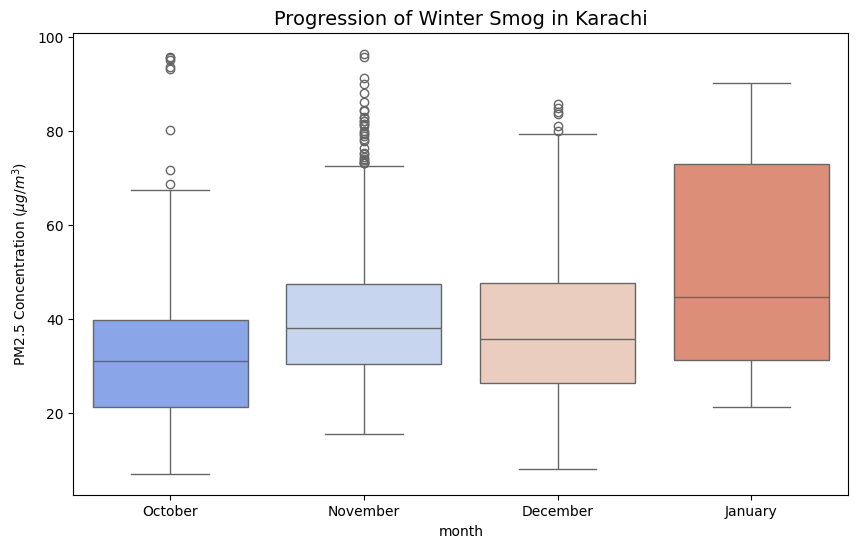

In [ ]:
# 3. Monthly Boxplots
df['month'] = df['time'].dt.month_name()
month_order = ['October', 'November', 'December', 'January']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='month', y='pm2_5', order=month_order, palette='coolwarm')

plt.title('Progression of Winter Smog in Karachi', fontsize=14)
plt.ylabel(r'PM2.5 Concentration ($\mu g/m^3$)')
plt.show()

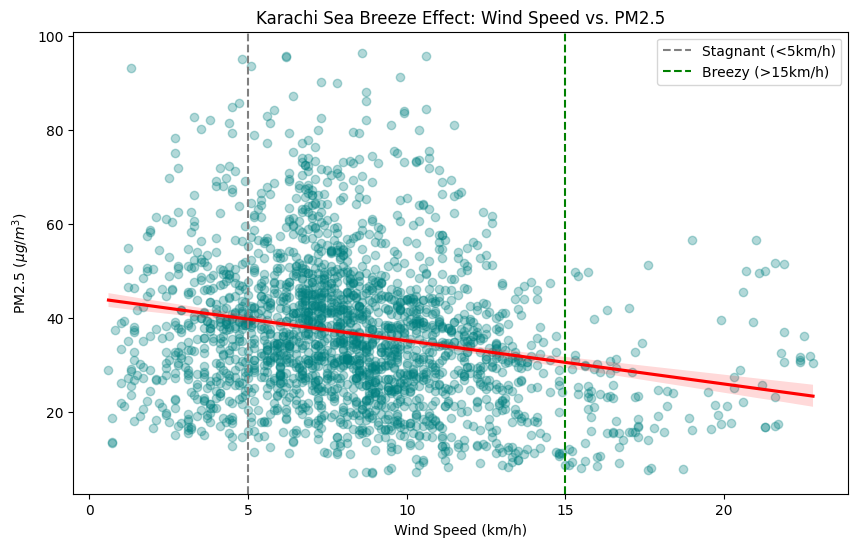

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. The "Sea Breeze" Savior: Wind Speed vs. PM2.5
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='wind_speed_10m', y='pm2_5',
            scatter_kws={'alpha':0.3, 'color':'teal'}, line_kws={'color':'red'})
plt.title('Karachi Sea Breeze Effect: Wind Speed vs. PM2.5')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel(r'PM2.5 ($\mu g/m^3$)')
plt.axvline(x=5, color='gray', linestyle='--', label='Stagnant (<5km/h)')
plt.axvline(x=15, color='green', linestyle='--', label='Breezy (>15km/h)')
plt.legend()
plt.show()

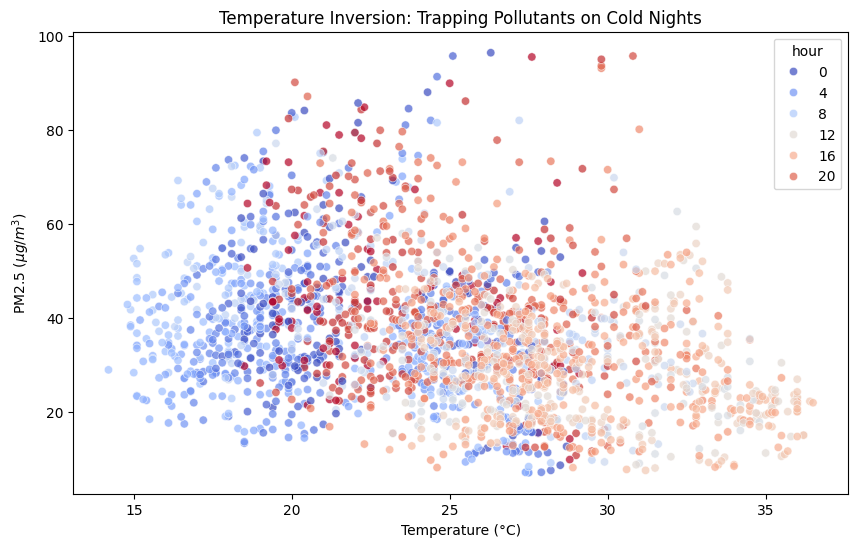

In [ ]:
# 3. The Temperature Inversion: Temperature vs. PM2.5
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='temp', y='pm2_5', hue='hour', palette='coolwarm', alpha=0.7)
plt.title('Temperature Inversion: Trapping Pollutants on Cold Nights')
plt.xlabel('Temperature (°C)')
plt.ylabel(r'PM2.5 ($\mu g/m^3$)')
plt.show()

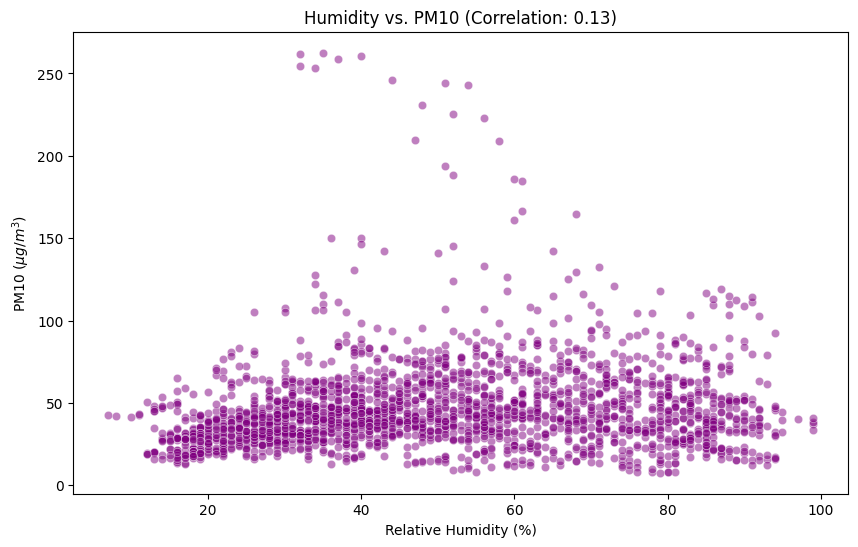

In [ ]:
# 4. Humidity & Particulates: Correlation with PM10
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='humidity', y='pm10', alpha=0.5, color='purple')
plt.title(f"Humidity vs. PM10 (Correlation: {df['humidity'].corr(df['pm10']):.2f})")
plt.xlabel('Relative Humidity (%)')
plt.ylabel(r'PM10 ($\mu g/m^3$)')
plt.show()

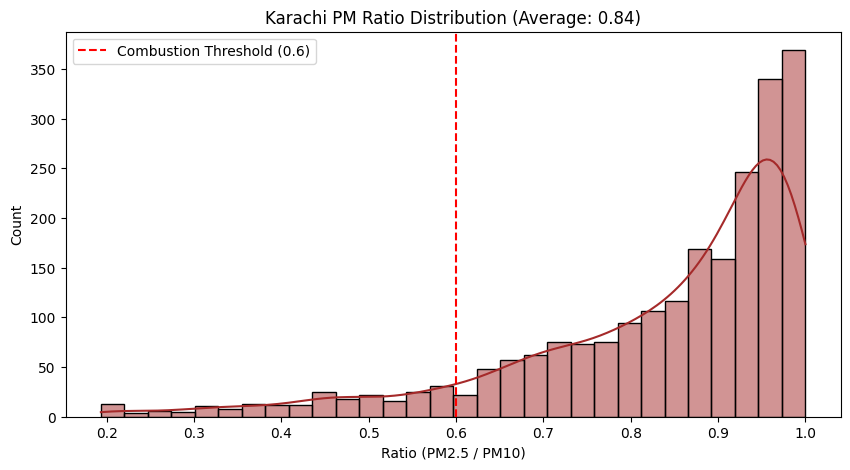

In [ ]:
# 1. Pollutant Ratios (PM2.5 / PM10)
df['pm_ratio'] = df['pm2_5'] / df['pm10']
avg_ratio = df['pm_ratio'].mean()

plt.figure(figsize=(10, 5))
sns.histplot(df['pm_ratio'], bins=30, kde=True, color='brown')
plt.axvline(0.6, color='red', linestyle='--', label='Combustion Threshold (0.6)')
plt.title(f'Karachi PM Ratio Distribution (Average: {avg_ratio:.2f})')
plt.xlabel('Ratio (PM2.5 / PM10)')
plt.legend()
plt.show()

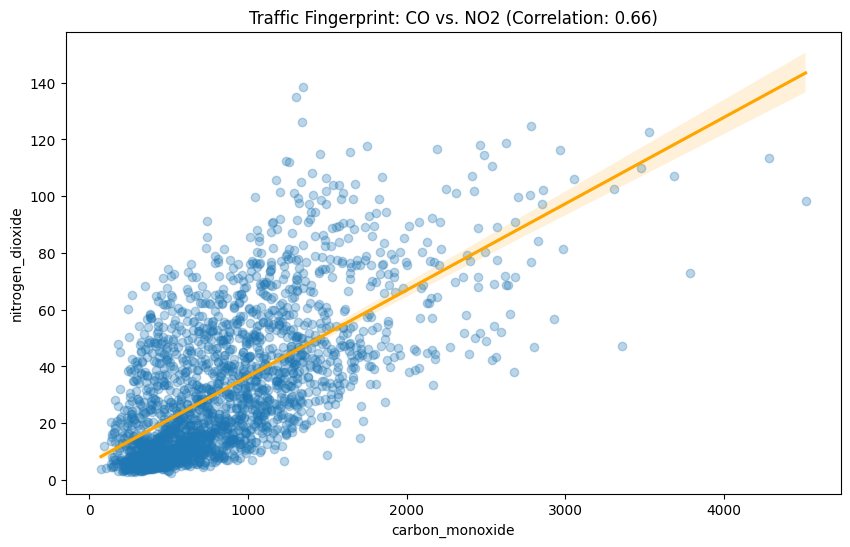

In [ ]:
# 2. CO vs. NO2 Correlation (Traffic Fingerprint)
# Checking for carbon_monoxide and nitrogen_dioxide in your df
if 'carbon_monoxide' in df.columns and 'nitrogen_dioxide' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.regplot(data=df, x='carbon_monoxide', y='nitrogen_dioxide',
                scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
    traffic_corr = df['carbon_monoxide'].corr(df['nitrogen_dioxide'])
    plt.title(f'Traffic Fingerprint: CO vs. NO2 (Correlation: {traffic_corr:.2f})')
    plt.show()

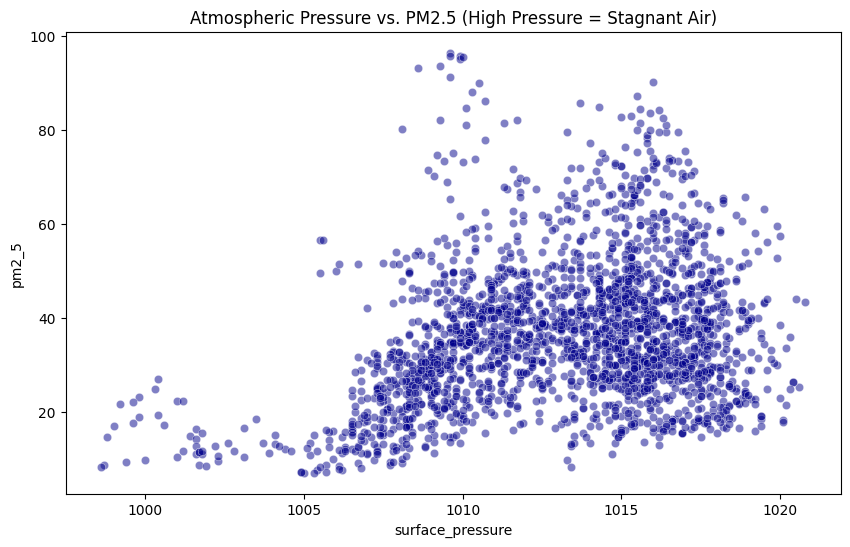

In [ ]:
# 3. Surface Pressure Trends (Stagnant Air)
pressure_col = 'surface_pressure' if 'surface_pressure' in df.columns else 'pressure_msl'
if pressure_col in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=pressure_col, y='pm2_5', alpha=0.5, color='darkblue')
    plt.title('Atmospheric Pressure vs. PM2.5 (High Pressure = Stagnant Air)')
    plt.show()

Detected 36 hours of rain.
Average PM2.5 (Dry): 36.9 µg/m³
Average PM2.5 (Rain): 17.1 µg/m³


/tmp/ipython-input-2783336893.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Dry', 'Rainy'], y=[avg_dry, avg_wet], palette='Blues_d')


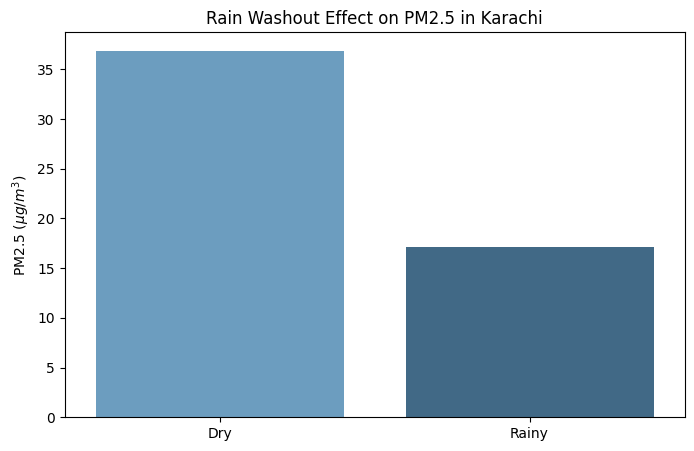

In [ ]:
# 4. Precipitation Washout (The Rain Effect)
rainy_hours = df[df['precipitation'] > 0]

if not rainy_hours.empty:
    print(f"Detected {len(rainy_hours)} hours of rain.")
    avg_dry = df[df['precipitation'] == 0]['pm2_5'].mean()
    avg_wet = rainy_hours['pm2_5'].mean()
    print(f"Average PM2.5 (Dry): {avg_dry:.1f} µg/m³")
    print(f"Average PM2.5 (Rain): {avg_wet:.1f} µg/m³")

    plt.figure(figsize=(8, 5))
    sns.barplot(x=['Dry', 'Rainy'], y=[avg_dry, avg_wet], palette='Blues_d')
    plt.title('Rain Washout Effect on PM2.5 in Karachi')
    plt.ylabel(r'PM2.5 ($\mu g/m^3$)')
    plt.show()
else:
    print("No precipitation detected in this dataset (Typical dry Karachi Winter).")

<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3922929130.py:29: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline(SEQS_PM25, color='red', linestyle='--', linewidth=2, label=f'SEQS Limit ({SEQS_PM25} $\mu g/m^3$)')


--- KARACHI LEGAL COMPLIANCE SUMMARY ---
Total Monitored Hours: 2232
PM2.5 Hours > 75 (SEQS Limit): 44 (1.97%)
PM10 Hours > 150 (SEQS Limit): 22 (0.99%)
----------------------------------------


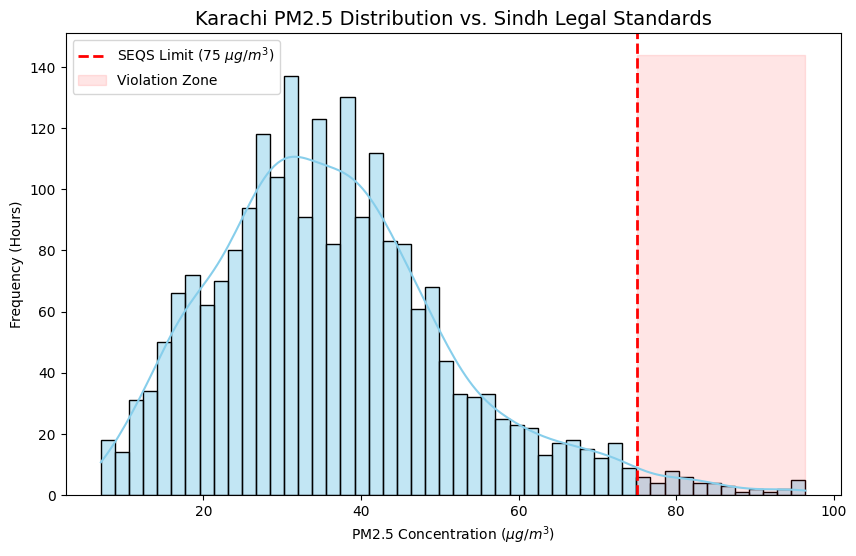

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- SINDH ENVIRONMENTAL QUALITY STANDARDS (SEQS) ---
SEQS_PM25 = 75
SEQS_PM10 = 150

# 1. Calculate Violation Statistics
total_hours = len(df)
pm25_violations = (df['pm2_5'] > SEQS_PM25).sum()
pm10_violations = (df['pm10'] > SEQS_PM10).sum()

pm25_perc = (pm25_violations / total_hours) * 100
pm10_perc = (pm10_violations / total_hours) * 100

# 2. Print Outcomes
print("--- KARACHI LEGAL COMPLIANCE SUMMARY ---")
print(f"Total Monitored Hours: {total_hours}")
print(f"PM2.5 Hours > {SEQS_PM25} (SEQS Limit): {pm25_violations} ({pm25_perc:.2f}%)")
print(f"PM10 Hours > {SEQS_PM10} (SEQS Limit): {pm10_violations} ({pm10_perc:.2f}%)")
print("-" * 40)

# 3. Compliance Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['pm2_5'], bins=50, color='skyblue', kde=True)

# Add legal limit line and highlight the violation zone
plt.axvline(SEQS_PM25, color='red', linestyle='--', linewidth=2, label=f'SEQS Limit ({SEQS_PM25} $\mu g/m^3$)')
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], SEQS_PM25, df['pm2_5'].max(), color='red', alpha=0.1, label='Violation Zone')

plt.title('Karachi PM2.5 Distribution vs. Sindh Legal Standards', fontsize=14)
plt.xlabel(r'PM2.5 Concentration ($\mu g/m^3$)')
plt.ylabel('Frequency (Hours)')
plt.legend()
plt.show()

In [ ]:
# 1. Count how many hours actually had any moisture
total_hours = len(df)
rainy_hours = (df['precipitation'] > 0).sum()
trace_hours = (df['precipitation'] == 0.1).sum()

print(f"Total Hours Analyzed: {total_hours}")
print(f"Hours with any Precipitation (>0): {rainy_hours}")
print(f"Hours with 'Trace' (exactly 0.1mm): {trace_hours}")

# 2. See the max rain recorded
max_rain = df['precipitation'].max()
print(f"Heaviest Rainfall in 1 hour: {max_rain} mm")

Total Hours Analyzed: 2232
Hours with any Precipitation (>0): 36
Hours with 'Trace' (exactly 0.1mm): 16
Heaviest Rainfall in 1 hour: 2.1 mm


In [ ]:
# 1. Find the exact time of the heaviest rain
heaviest_rain_row = df[df['precipitation'] == df['precipitation'].max()]
rain_time = heaviest_rain_row['time'].iloc[0]
pm_before = df.iloc[heaviest_rain_row.index[0] - 1]['pm2_5']
pm_during = heaviest_rain_row['pm2_5'].iloc[0]

print(f"--- THE WASHOUT TEST ---")
print(f"Heaviest Rain Time: {rain_time}")
print(f"PM2.5 Before Rain: {pm_before:.1f} µg/m³")
print(f"PM2.5 During Rain: {pm_during:.1f} µg/m³")

reduction = ((pm_before - pm_during) / pm_before) * 100
print(f"Pollution Reduction: {reduction:.1f}%")

--- THE WASHOUT TEST ---
Heaviest Rain Time: 2025-10-04 00:00:00
PM2.5 Before Rain: 12.7 µg/m³
PM2.5 During Rain: 12.3 µg/m³
Pollution Reduction: 3.1%


In [ ]:
# 1. Check for missing values in each column
null_counts = df.isnull().sum()

# 2. Check for the percentage of missing data
null_percentage = (df.isnull().sum() / len(df)) * 100

# 3. Combine into a summary table
null_summary = pd.DataFrame({
    'Missing Values': null_counts,
    'Percentage (%)': null_percentage
})

print("--- DATASET INTEGRITY CHECK ---")
if null_counts.sum() == 0:
    print("✅ GREAT NEWS: Your dataset has ZERO null values. Your analysis is solid.")
else:
    print("⚠️ WARNING: Missing values detected!")
    print(null_summary[null_summary['Missing Values'] > 0])

# 4. Final check: Look for '0' values that might actually be missing data
# (Sometimes sensors record 0.0 when they fail)
pm25_zeros = (df['pm2_5'] == 0).sum()
print(f"\nHours where PM2.5 is exactly 0: {pm25_zeros}")

--- DATASET INTEGRITY CHECK ---
✅ GREAT NEWS: Your dataset has ZERO null values. Your analysis is solid.

Hours where PM2.5 is exactly 0: 0
